In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from boundary import Dirichlet, Periodic, Neumann
from mesh import Data, Mesh_Data
from solver import PDE
from models import *
from models.activation import Sine, Swish

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$


In [2]:
c = 1.
class Linear_Conv(PDE):
    
    def PDELoss(self, inputs, outputs):
        
        # compute gradients
        grads = self.compute_grad(outputs, inputs)
        
        # dudt
        dudt = grads[:,1]
        
        # dudx
        dudx = grads[:,0]
        
        return {'ODE': dudt + c*dudx}
ode = Linear_Conv(inputs=('x','t'),outputs=('u'))

pass


In [3]:
# define the mesh
x = np.linspace(0,2,80)
t = np.linspace(0,1,40)
mesh = Mesh_Data({'x':x, 't':t})
ode.set_mesh(mesh)

In [4]:
# x_init_2

In [5]:
# initial condition 
# u = 2 (0.5 <= x <= 1) and elsewhere u =1
x_init_1 = x[np.where((x >= 0.5)&(x<=1.))]
u_1 = np.full(len(x_init_1), 2.)

initial_1 = Dirichlet({'x':x_init_1, 't':np.array([0])},{'u':u_1}, name='Initial_1')

# second cond
x_init_2 = np.array([i for i in x if i not in x_init_1])
u_2 = np.full(len(x_init_2), 1.)

initial_2 = Dirichlet({'x':x_init_2.reshape(-1), 't':np.array([0])},{'u':u_2.reshape(-1)}, name='Initial_2')

In [6]:
ode.add_boundary(initial_1)
ode.add_boundary(initial_2)

In [7]:
activation = Sine()
#activation = torch.nn.ELU()
in_dim = len(ode.input)
hid_dim = 100
out_dim = len(ode.output)
layers = 3
net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)
epochs = 50
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, pct_start = 0.1, total_steps = epochs)
ode.compile(net, optimizer, scheduler)

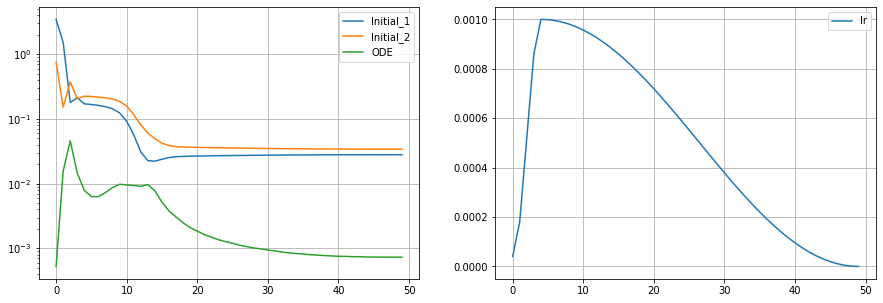

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 39.9 s


In [8]:
batch_size = 120
%time hist = ode.solve(epochs, batch_size)

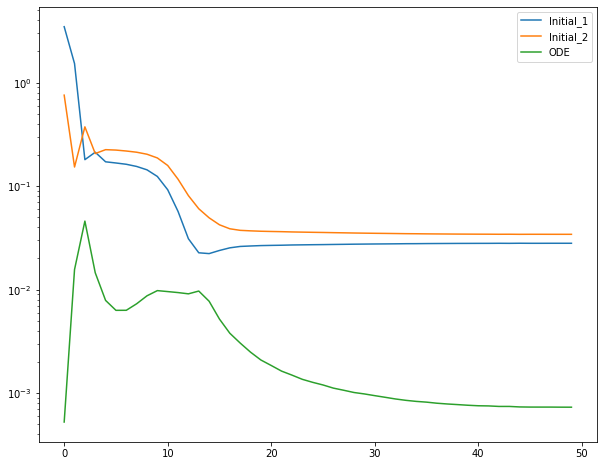

In [9]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [10]:
# evaluate the results
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
eval_mesh = Mesh_Data({'x':x, 't':t})
pred = ode.eval(eval_mesh)

In [11]:
pred.numpy().shape

(600, 1)

In [12]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, t, p):
    ax.clear()
    #pe = np.sin(2.*np.pi*(x-u*t[i]))
    #ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
#     ax.set_xlim([0, 1])
#     ax.set_ylim([-1.2, 1.2])
    #l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} ")
    return ax

In [1]:
x = np.linspace(0,2,60)
t = np.array([1.])

eval_mesh = Mesh_Data({'x':x, 't':t})

pred = ode.eval(eval_mesh)
pred = pred.numpy().reshape(len(t),-1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames = len(t), fargs=(x,t,pred), interval = 300)
plt.close()

NameError: name 'np' is not defined

In [14]:
anim

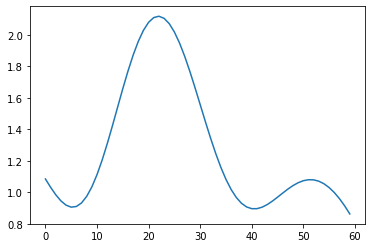

In [15]:
plt.plot(pred.reshape(-1))

In [16]:
from NET_Solver import MLP

ModuleNotFoundError: No module named 'NET_Solver'

In [87]:
class Laplace(PDE):
    def PDELoss(self, inputs, outputs):
        
        # compute grad
        grad = self.compute_grad(outputs, inputs)
        grad2 = self.compute_grad(grad, inputs)
        
        # derivative
        dp2dx2 = grad2[:,0]
        dp2dy2 = grad2[:,1]
        
        return {'PDE': dp2dx2 + dp2dy2}

In [88]:
pde = Laplace(inputs=('x','y'),outputs='p')

pass


In [89]:
# define the mesh
x = np.linspace(0,2,80)
y = np.linspace(0,1,40)
mesh = Mesh_Data({'x':x, 'y':y})
pde.set_mesh(mesh)

In [90]:
# Boundary condtions
# P = 0 @ x=0
bound_1 = Dirichlet({'x':np.array([0]), 'y':y},{'p':np.full(len(y),0)}, name='Bound_1')
pde.add_boundary(bound_1)

In [91]:
# p = y @ x=2
bound_2 = Dirichlet({'x':np.array([2]),'y':y},{'p':y}, name='Bound_2')
pde.add_boundary(bound_2)

In [92]:
# neumann Boundary
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dpdy = self.compute_grad(outputs, inputs)[:,1]
        return {'gradY_0': dpdy}
    
bound_3 = Neumann({'x':x, 'y':np.array([0])}, name='Bound_3')
pde.add_boundary(bound_3)


In [93]:
# neumann Boundary
class Neumann_1(Neumann):
    def neumann_loss(self, inputs, outputs):
        dpdy = self.compute_grad(outputs, inputs)[:,1]
        return {'gradY_1': dpdy}
    
bound_4 = Neumann_1({'x':x, 'y':np.array([1])}, name='Bound_4')
pde.add_boundary(bound_4)

In [94]:
btach_size = 1024
lr = 5e-3
epochs = 100
hid_dim = 250
layers = 3
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Swish(10)


net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)


pde.compile(net,optimizer, scheduler)

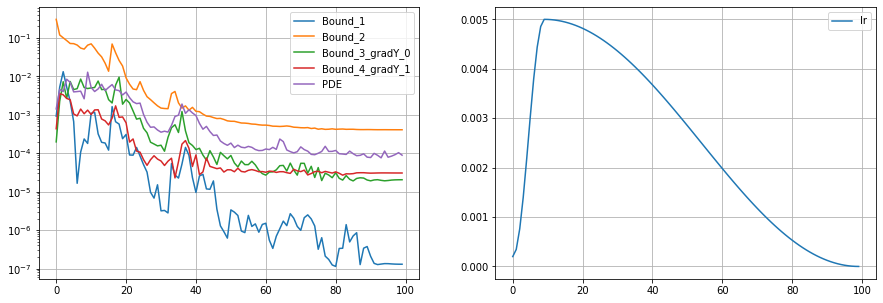

Wall time: 1min 40s


In [95]:
%time hist = pde.solve(epochs, btach_size)

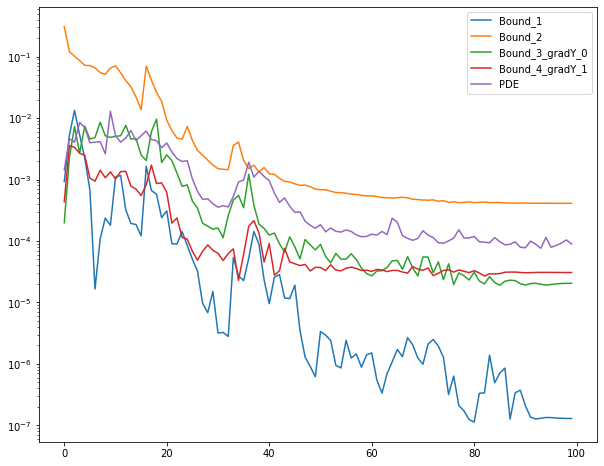

In [96]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

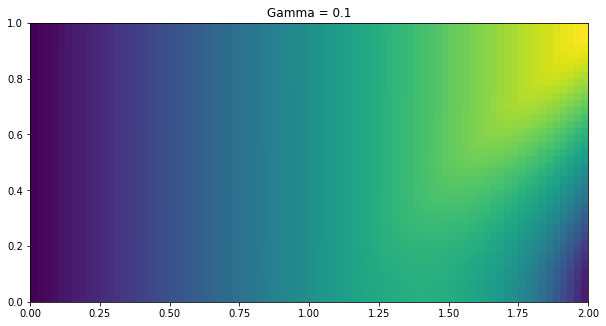

In [100]:
x = np.linspace(0,2,80)
y = np.linspace(0,1,40)

eval_mesh = Mesh_Data({'x':x, 'y':y})
pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(pred, vmin=pred.min(),vmax= pred.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_title('Gamma = 0.1')
plt.show()

In [101]:
def plot2D(x, y, p):
    fig = pyplot.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')


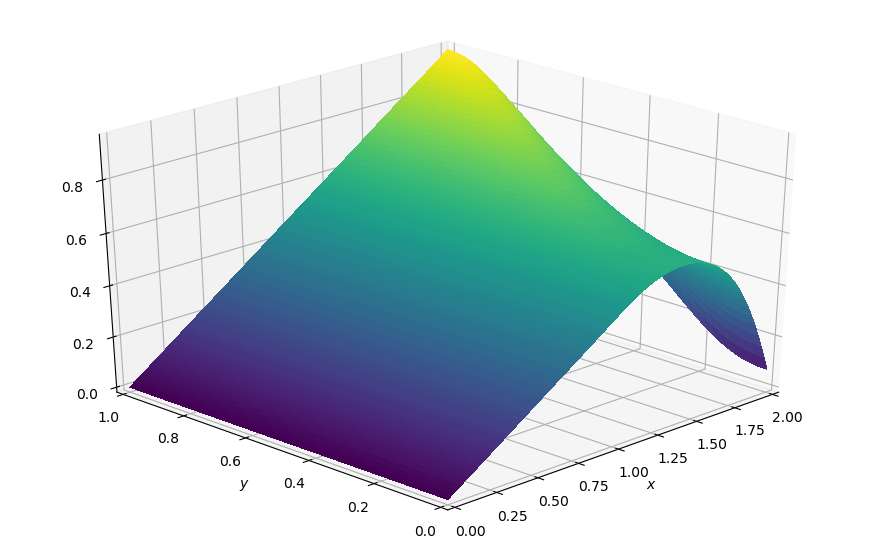

In [102]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plot2D(x, y, pred)